# 1 IMPORTS

In [119]:
import pandas as pd
import numpy as np
import inflection
from scipy.stats import skew, kurtosis, chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


from IPython.core.display import HTML
from IPython.display import Image

## 1.1 Helper Functions

In [131]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    pd.options.display.float_format = '{:,.2f}'.format
    
    sns.set()
    
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [74]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 1.2 Loading data

In [75]:
#Two different files, store has the information about promotions, etc. 
#Sales reports the sales of each store day by day in a ~2 year interval

df_raw_store = pd.read_csv('../data/store.csv', low_memory=False)
df_raw_sales = pd.read_csv('../data/train.csv', low_memory=False)

df_raw = pd.merge(df_raw_store, df_raw_sales, how='left', on='Store')

In [76]:
df_raw[df_raw['Store']==1115]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1016267,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",5,2015-07-31,8680,538,1,1,0,1
1016268,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",4,2015-07-30,8405,502,1,1,0,1
1016269,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",3,2015-07-29,7661,473,1,1,0,1
1016270,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",2,2015-07-28,8093,500,1,1,0,1
1016271,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",1,2015-07-27,10712,608,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",6,2013-01-05,4771,339,1,0,0,1
1017205,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",5,2013-01-04,4540,326,1,0,0,1
1017206,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",4,2013-01-03,4297,300,1,0,0,1
1017207,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",3,2013-01-02,3697,305,1,0,0,1


# 2 DATA DESCRIPTION

In [77]:
df2 = df_raw.copy()
df2

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,c,a,"1,270.00",9.00,"2,008.00",0,NaN,NaN,NaN,5,2015-07-31,5263,555,1,1,0,1
1,1,c,a,"1,270.00",9.00,"2,008.00",0,NaN,NaN,NaN,4,2015-07-30,5020,546,1,1,0,1
2,1,c,a,"1,270.00",9.00,"2,008.00",0,NaN,NaN,NaN,3,2015-07-29,4782,523,1,1,0,1
3,1,c,a,"1,270.00",9.00,"2,008.00",0,NaN,NaN,NaN,2,2015-07-28,5011,560,1,1,0,1
4,1,c,a,"1,270.00",9.00,"2,008.00",0,NaN,NaN,NaN,1,2015-07-27,6102,612,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",6,2013-01-05,4771,339,1,0,0,1
1017205,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",5,2013-01-04,4540,326,1,0,0,1
1017206,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",4,2013-01-03,4297,300,1,0,0,1
1017207,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",3,2013-01-02,3697,305,1,0,0,1


## 2.1 Rename Columns

In [78]:
#i will be using snakecase for this project, so might turn it a standard

cols = df2.columns
snakecase_function = lambda x: inflection.underscore( x )
cols_new = list( map(snakecase_function, cols) )
df2.columns = cols_new
df2 = df2.rename(columns={'promo_interval':'promo2_interval'})

df2

,store,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo2_interval,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday
0,1,c,a,"1,270.00",9.00,"2,008.00",0,NaN,NaN,NaN,5,2015-07-31,5263,555,1,1,0,1
1,1,c,a,"1,270.00",9.00,"2,008.00",0,NaN,NaN,NaN,4,2015-07-30,5020,546,1,1,0,1
2,1,c,a,"1,270.00",9.00,"2,008.00",0,NaN,NaN,NaN,3,2015-07-29,4782,523,1,1,0,1
3,1,c,a,"1,270.00",9.00,"2,008.00",0,NaN,NaN,NaN,2,2015-07-28,5011,560,1,1,0,1
4,1,c,a,"1,270.00",9.00,"2,008.00",0,NaN,NaN,NaN,1,2015-07-27,6102,612,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",6,2013-01-05,4771,339,1,0,0,1
1017205,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",5,2013-01-04,4540,326,1,0,0,1
1017206,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",4,2013-01-03,4297,300,1,0,0,1
1017207,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",3,2013-01-02,3697,305,1,0,0,1


In [79]:
df2

,store,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo2_interval,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday
0,1,c,a,"1,270.00",9.00,"2,008.00",0,NaN,NaN,NaN,5,2015-07-31,5263,555,1,1,0,1
1,1,c,a,"1,270.00",9.00,"2,008.00",0,NaN,NaN,NaN,4,2015-07-30,5020,546,1,1,0,1
2,1,c,a,"1,270.00",9.00,"2,008.00",0,NaN,NaN,NaN,3,2015-07-29,4782,523,1,1,0,1
3,1,c,a,"1,270.00",9.00,"2,008.00",0,NaN,NaN,NaN,2,2015-07-28,5011,560,1,1,0,1
4,1,c,a,"1,270.00",9.00,"2,008.00",0,NaN,NaN,NaN,1,2015-07-27,6102,612,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",6,2013-01-05,4771,339,1,0,0,1
1017205,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",5,2013-01-04,4540,326,1,0,0,1
1017206,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",4,2013-01-03,4297,300,1,0,0,1
1017207,1115,d,c,"5,350.00",NaN,NaN,1,22.00,"2,012.00","Mar,Jun,Sept,Dec",3,2013-01-02,3697,305,1,0,0,1


## 2.2 Data Dimensions

In [80]:
print(f'Number of lines: {df2.shape[0]}')
print(f'Number of columns: {df2.shape[0]}')

Number of lines: 1017209
Number of columns: 1017209


## 2.3 Data Types

In [81]:
#need to fill NA before changing datatypes
df2.dtypes

store                             int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo2_interval                  object
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
dtype: object

In [82]:
#I am doing this here because i will need it for filling NA, otherwise it would be on change data types section
df2['date'] = pd.to_datetime( df2['date'] )

## 2.4 Check NA

In [83]:
df2.isna().sum()

store                                0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo2_interval                 508031
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
dtype: int64

## 2.5 Fillout NA

In [84]:
df2.describe()

,store,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,day_of_week,sales,customers,open,promo,school_holiday
count,"1,017,209.00","1,014,567.00","693,861.00","693,861.00","1,017,209.00","509,178.00","509,178.00","1,017,209.00","1,017,209.00","1,017,209.00","1,017,209.00","1,017,209.00","1,017,209.00"
mean,558.43,"5,430.09",7.22,"2,008.69",0.50,23.27,"2,011.75",4.00,"5,773.82",633.15,0.83,0.38,0.18
std,321.91,"7,715.32",3.21,5.99,0.50,14.10,1.66,2.00,"3,849.93",464.41,0.38,0.49,0.38
min,1.00,20.00,1.00,"1,900.00",0.00,1.00,"2,009.00",1.00,0.00,0.00,0.00,0.00,0.00
25%,280.00,710.00,4.00,"2,006.00",0.00,13.00,"2,011.00",2.00,"3,727.00",405.00,1.00,0.00,0.00
50%,558.00,"2,330.00",8.00,"2,010.00",1.00,22.00,"2,012.00",4.00,"5,744.00",609.00,1.00,0.00,0.00
75%,838.00,"6,890.00",10.00,"2,013.00",1.00,37.00,"2,013.00",6.00,"7,856.00",837.00,1.00,1.00,0.00
max,"1,115.00","75,860.00",12.00,"2,015.00",1.00,50.00,"2,015.00",7.00,"41,551.00","7,388.00",1.00,1.00,1.00


In [85]:
# competition_distance - set a distance 4 times bigger than the max value when there is no competition
df2['competition_distance'] = df2['competition_distance'].apply(lambda x: 300000 if np.isnan( x ) else x )

# competition_open_since_month - The idea to deal with those variables is 
# to say there are zero days since competition opened, I just set those to be equal to the date
df2['competition_open_since_month'] = df2.apply( lambda x: x['date'].month 
                                                if np.isnan(x['competition_open_since_month']) 
                                                else x['competition_open_since_month'], axis=1)

# competition_open_since_year

df2['competition_open_since_year'] = df2.apply( lambda x: x['date'].year 
                                               if np.isnan(x['competition_open_since_year']) 
                                               else x['competition_open_since_year'], axis=1)

# promo2_since_week

df2['promo2_since_week'] = df2.apply( lambda x: x['date'].week 
                                     if np.isnan(x['promo2_since_week']) 
                                     else x['promo2_since_week'], axis=1)

# promo2_since_year
df2['promo2_since_year'] = df2.apply( lambda x: x['date'].year 
                                     if np.isnan(x['promo2_since_year']) 
                                     else x['promo2_since_year'], axis=1)

# promo_interval - we can just set to 0 when there is no promo
df2['promo2_interval'].fillna(0, inplace=True)

#now I need a feature that describes whether the store is in promo2 or not since those infos are in different files
# promo2 column just says if the store participates or not in promo2, not if it is active
months = ('Jan', 'Feb', 'Mar', 'Apr', 'May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')
month_map = {i+1: months[i] for i in range(12)}

df2['date_month'] = df2['date'].dt.month.map( month_map )

df2['is_promo2'] = df2[['date_month', 'promo2_interval']].apply(lambda x: 0 if x['promo2_interval'] == 0 else 
                                                               1 if x['date_month'] in x['promo2_interval'].split(',') 
                                                               else 0, axis=1 )

## 2.6 Change Data Types

In [86]:
df2 = df2.astype( {'competition_open_since_month':'int64',
            'competition_open_since_year':'int64',
            'promo2_since_week':'int64',
            'promo2_since_year':'int64'} ) 
df2.dtypes

store                                    int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo2_interval                         object
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
date_month                              object
is_promo2                                int64
dtype: object

## 2.7 Descriptive Statistics

In [87]:
num_attributes = df2.select_dtypes(include=['float64','int64'])
cat_attributes = df2.select_dtypes(exclude=['float64','int64','datetime64[ns]'])

### 2.7.1 Numerical Atributes

In [88]:
#attributes to evaluate: mean, median, std, min, max, range, skew, kurtosis

d1 = np.mean(num_attributes)
d2 = pd.Series(np.median(num_attributes, axis=0), index=d1.index)
d3 = np.std(num_attributes)
d4 = np.min(num_attributes)
d5 = np.max(num_attributes)
d6 = d5-d4
d7 = pd.Series( skew(num_attributes), index= d1.index)
d8 = pd.Series( kurtosis(num_attributes), index= d1.index)

df_description = pd.concat([d1, d2, d3, d4, d5, d6, d7, d8], axis=1)
df_description.columns = ['mean', 'median', 'std', 'min', 'max', 'range', 'skew', 'kurtosis']

In [89]:
# quick statistical remark: skew means there is a tail to the right(positive) or the left(negative)
# kurtosis means it is sharper (>>0) or broader(<<0) than normal distribution

df_description

,mean,median,std,min,max,range,skew,kurtosis
store,558.43,558.00,321.91,1.00,"1,115.00","1,114.00",-0.00,-1.20
competition_distance,"6,195.17","2,330.00","16,856.98",20.00,"300,000.00","299,980.00",14.00,237.34
competition_open_since_month,6.79,7.00,3.31,1.00,12.00,11.00,-0.04,-1.23
competition_open_since_year,"2,010.32","2,012.00",5.52,"1,900.00","2,015.00",115.00,-7.24,124.07
promo2,0.50,1.00,0.50,0.00,1.00,1.00,-0.00,-2.00
promo2_since_week,23.62,22.00,14.31,1.00,52.00,51.00,0.18,-1.18
promo2_since_year,"2,012.79","2,013.00",1.66,"2,009.00","2,015.00",6.00,-0.78,-0.21
day_of_week,4.00,4.00,2.00,1.00,7.00,6.00,0.00,-1.25
sales,"5,773.82","5,744.00","3,849.92",0.00,"41,551.00","41,551.00",0.64,1.78
customers,633.15,609.00,464.41,0.00,"7,388.00","7,388.00",1.60,7.09


### 2.7.2 Categorical Atributes

In [90]:
cat_attributes.apply(lambda x: x.unique().shape[0], axis=0)

store_type          4
assortment          3
promo2_interval     4
state_holiday       4
date_month         12
dtype: int64

In [91]:
df2[df2['state_holiday'] != '0'].head()

,store,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo2_interval,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,date_month,is_promo2
57,1,c,a,"1,270.00",9,2008,0,23,2015,0,4,2015-06-04,0,0,0,1,a,0,Jun,0
67,1,c,a,"1,270.00",9,2008,0,22,2015,0,1,2015-05-25,0,0,0,0,a,0,May,0
78,1,c,a,"1,270.00",9,2008,0,20,2015,0,4,2015-05-14,0,0,0,0,a,0,May,0
91,1,c,a,"1,270.00",9,2008,0,18,2015,0,5,2015-05-01,0,0,0,1,a,0,May,0
116,1,c,a,"1,270.00",9,2008,0,15,2015,0,1,2015-04-06,0,0,0,0,b,1,Apr,0


<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

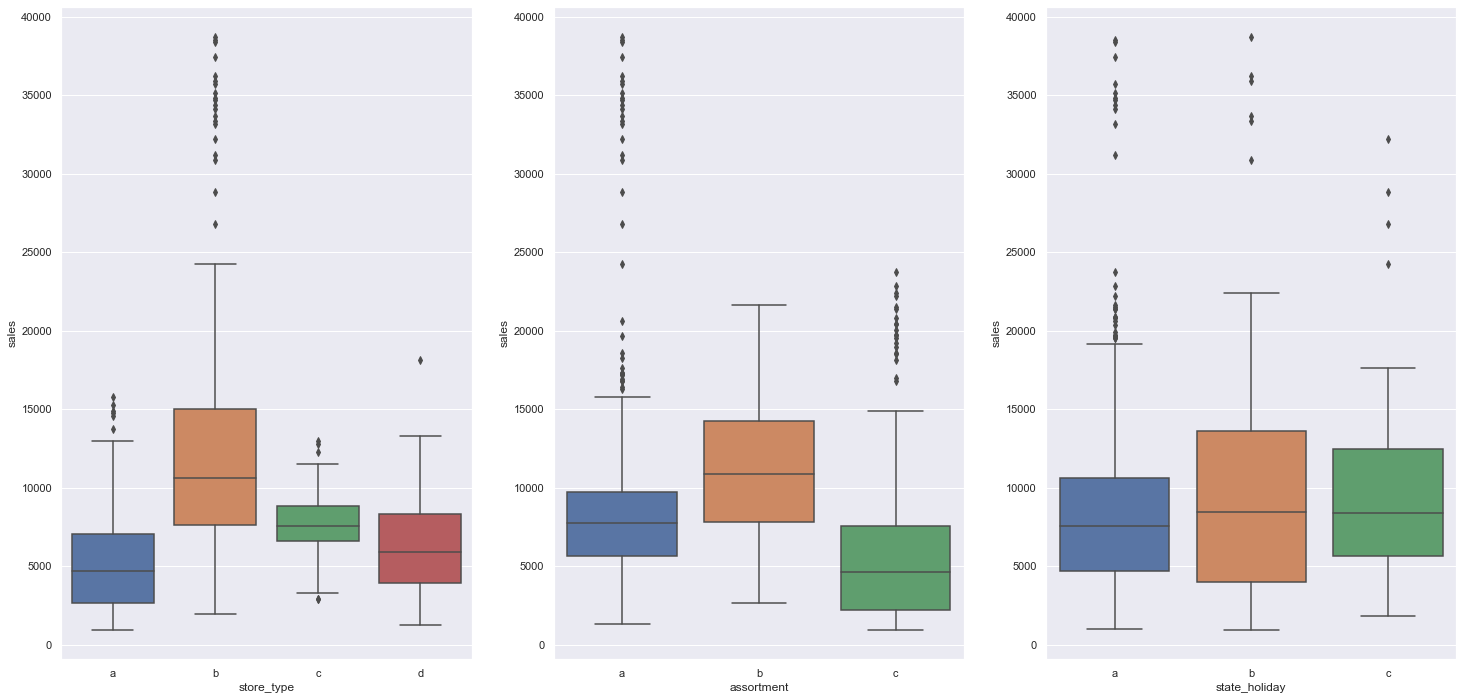

In [92]:
aux1 = df2[(df2['state_holiday'] != '0') & (df2['sales'] > 0) & (df2['state_holiday'] != 0)]

plt.subplot(1,3,1)
sns.boxplot(x='store_type', y='sales', data=aux1.sort_values(by='store_type'))

plt.subplot(1,3,2)
sns.boxplot(x='assortment', y='sales', data=aux1.sort_values(by='assortment'))

plt.subplot(1,3,3)
sns.boxplot(x='state_holiday', y='sales', data=aux1.sort_values(by='state_holiday'))

# 3 FEATURE ENGINEERING

In [93]:
df3 = df2.copy()

## 3.1 Hypothesis Mindmap

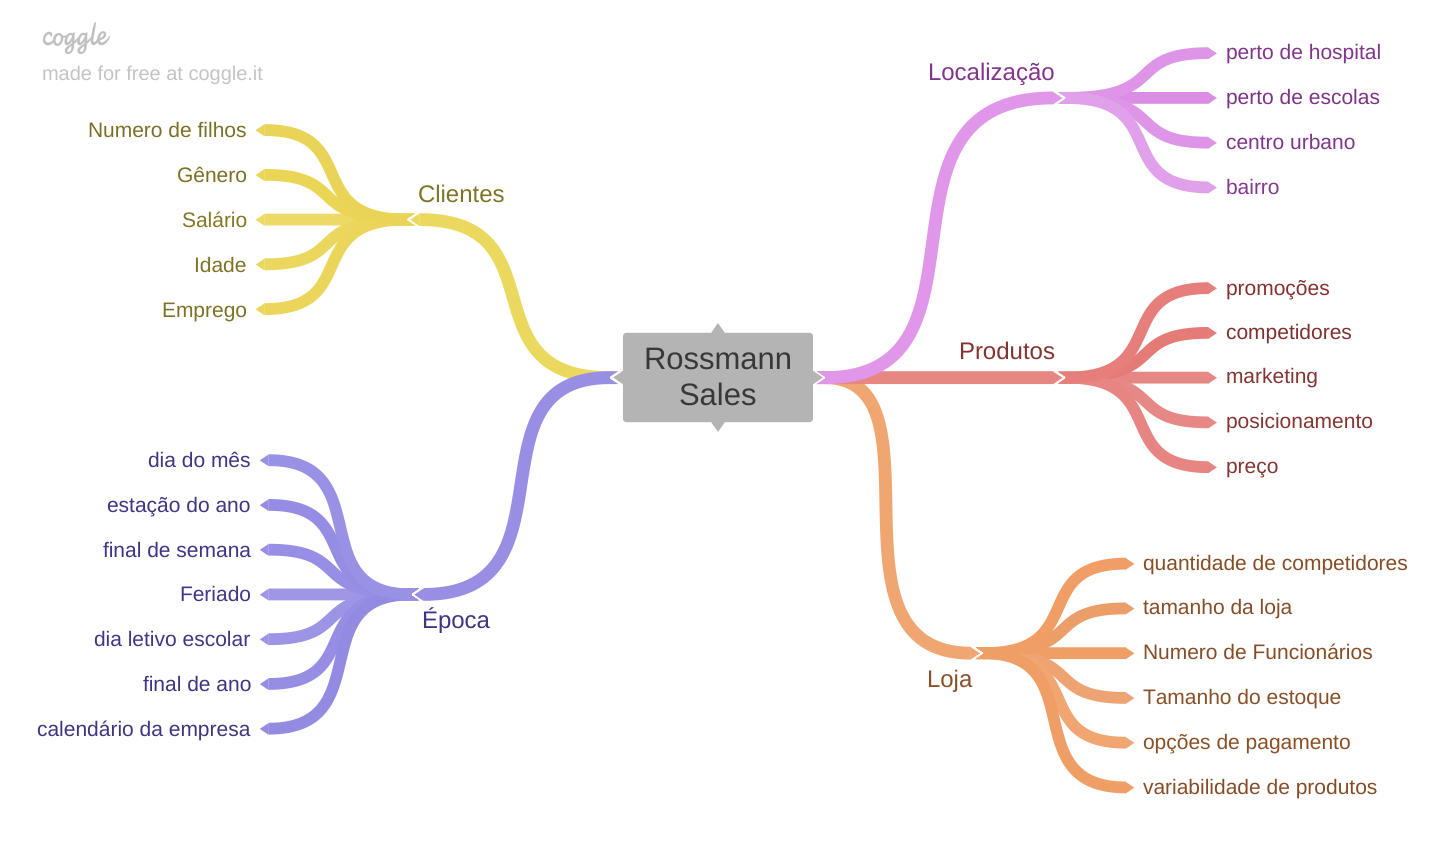

In [94]:
Image('../img/coggle_mindmap.png')

In [95]:
df3.head()

,store,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo2_interval,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,date_month,is_promo2
0,1,c,a,"1,270.00",9,2008,0,31,2015,0,5,2015-07-31,5263,555,1,1,0,1,Jul,0
1,1,c,a,"1,270.00",9,2008,0,31,2015,0,4,2015-07-30,5020,546,1,1,0,1,Jul,0
2,1,c,a,"1,270.00",9,2008,0,31,2015,0,3,2015-07-29,4782,523,1,1,0,1,Jul,0
3,1,c,a,"1,270.00",9,2008,0,31,2015,0,2,2015-07-28,5011,560,1,1,0,1,Jul,0
4,1,c,a,"1,270.00",9,2008,0,31,2015,0,1,2015-07-27,6102,612,1,1,0,1,Jul,0


In [96]:
df3['competition_open_since_year']

0          2008
1          2008
2          2008
3          2008
4          2008
           ... 
1017204    2013
1017205    2013
1017206    2013
1017207    2013
1017208    2013
Name: competition_open_since_year, Length: 1017209, dtype: int64

## 3.2 Business Hypothesis

- Sales should be uniform along the month (since Rosmmann is a drug store); 
- Sales should inccrease in the european winter;
- Sales should increase in promo days;
- Extended assortment stores should sell more;
- Multiple promotions should be better than just one;
- Sales should decrease with new competition opening;
- Closer competitors should decrease sales;
- there should be no difference between sales in holidays or regular days.



## 3.4 Feature Engineering

In [97]:
# # Now I will engineer the features necessary for checking the business hypothesis

# #first separate the date in day week, month, year

df3['day'] = df3['date'].dt.day

df3['weekofyear'] = df3['date'].dt.isocalendar().week

df3['month'] = df3['date'].dt.month

df3['year_week'] = df3['date'].dt.strftime( '%Y-%W' )

# recency of competition

df3['competition_open_date'] = df3[['competition_open_since_month', 'competition_open_since_year']].apply(
                            lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1 )

df3['competition_open_since'] = (df3['date'] - df3['competition_open_date']).dt.days


#since when there is the store under promo2
df3['promo2_since'] = df3['promo2_since_year'].astype( str ) + '-' + df3['promo2_since_week'].astype( str )
df3['promo2_since'] = df3['promo2_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df3['promo_time_week'] = ( ( df3['date'] - df3['promo2_since'] )/7 ).apply( lambda x: x.days ).astype( int )


# assortment
df3['assortment'] = df3['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df3['state_holiday'] = df3['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

# 4 DATA FILTERING

In [98]:
df4 = df3.copy()

## 4.1 Filter Rows

In [99]:
#I want to predict only when the store will actually have sales

df4 = df4[(df4['open'] != 0) & (df4['sales'] > 0)]

## 4.2 Filter Columns

In [100]:
#avoid data leakage and redundant information

df4.columns

cols_to_drop = ['customers', 'open', 'promo2_interval', 'date_month']

df4 = df4.drop(cols_to_drop, axis = 1)

# 5 EXPLORATORY DATA ANALYSIS

In [101]:
df5 = df4.copy() 

## 5.1 Univariate Analysis

### 5.1.1 Response Variable

<AxesSubplot:xlabel='sales', ylabel='Count'>

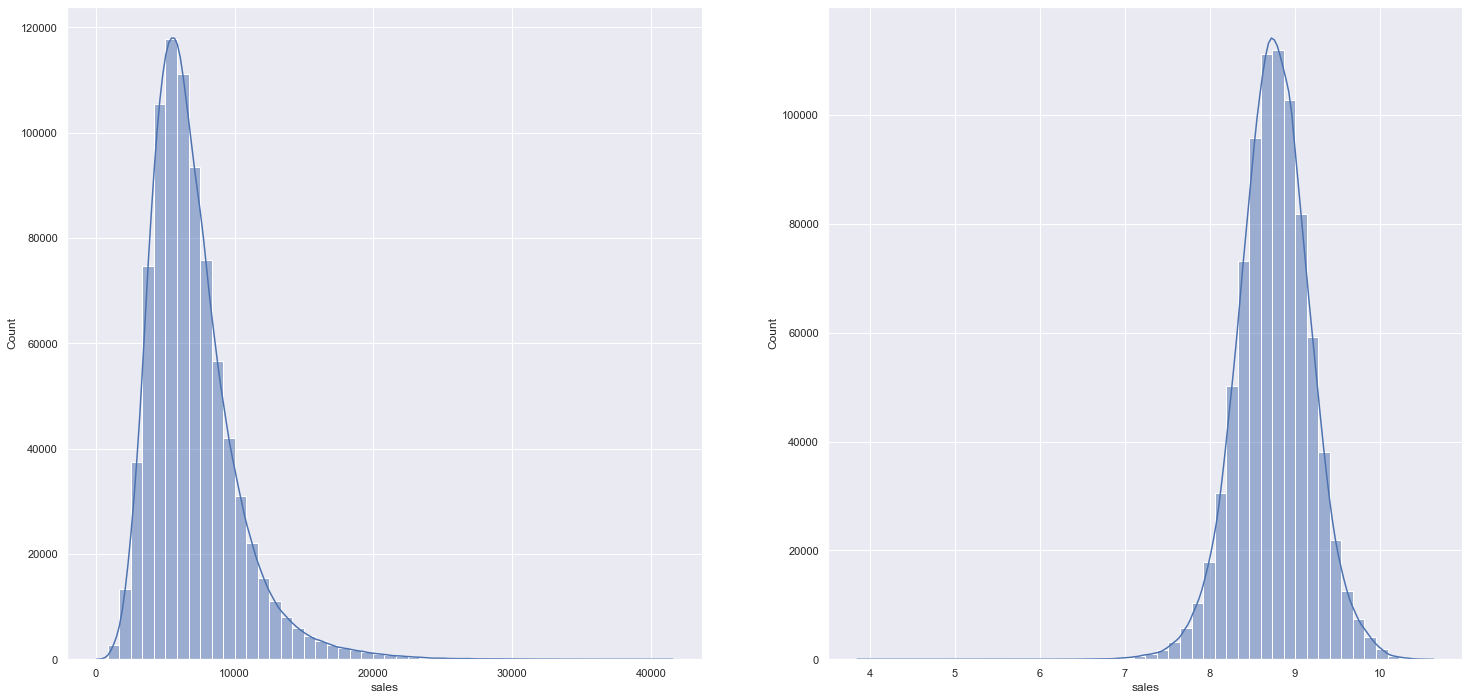

In [102]:
plt.figure()

plt.subplot(1,2,1)
sns.histplot(df5['sales'], bins=50, kde=True)

plt.subplot(1,2,2)
sns.histplot(np.log1p(df5['sales']), bins=50, kde=True)

#The log transformation approximates the response variable more to a normal distribution (no tail, lower skew),
# therefore it should lower the error

### 5.1.2 Numerical Variable

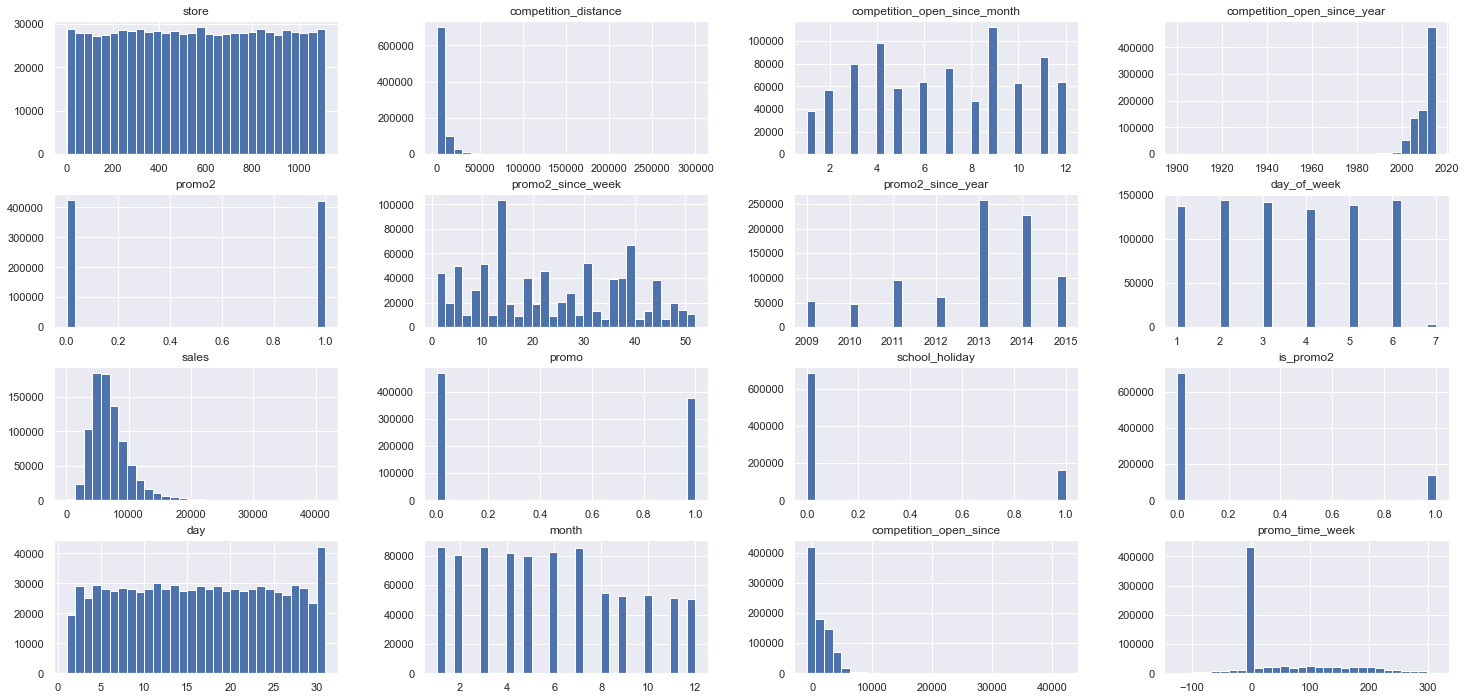

In [103]:
num_attributes = df5.select_dtypes(include=['int64', 'float64'])
num_attributes.hist(bins=30);

### 5.1.3 Categorical Variable

<AxesSubplot:xlabel='state_holiday', ylabel='count'>

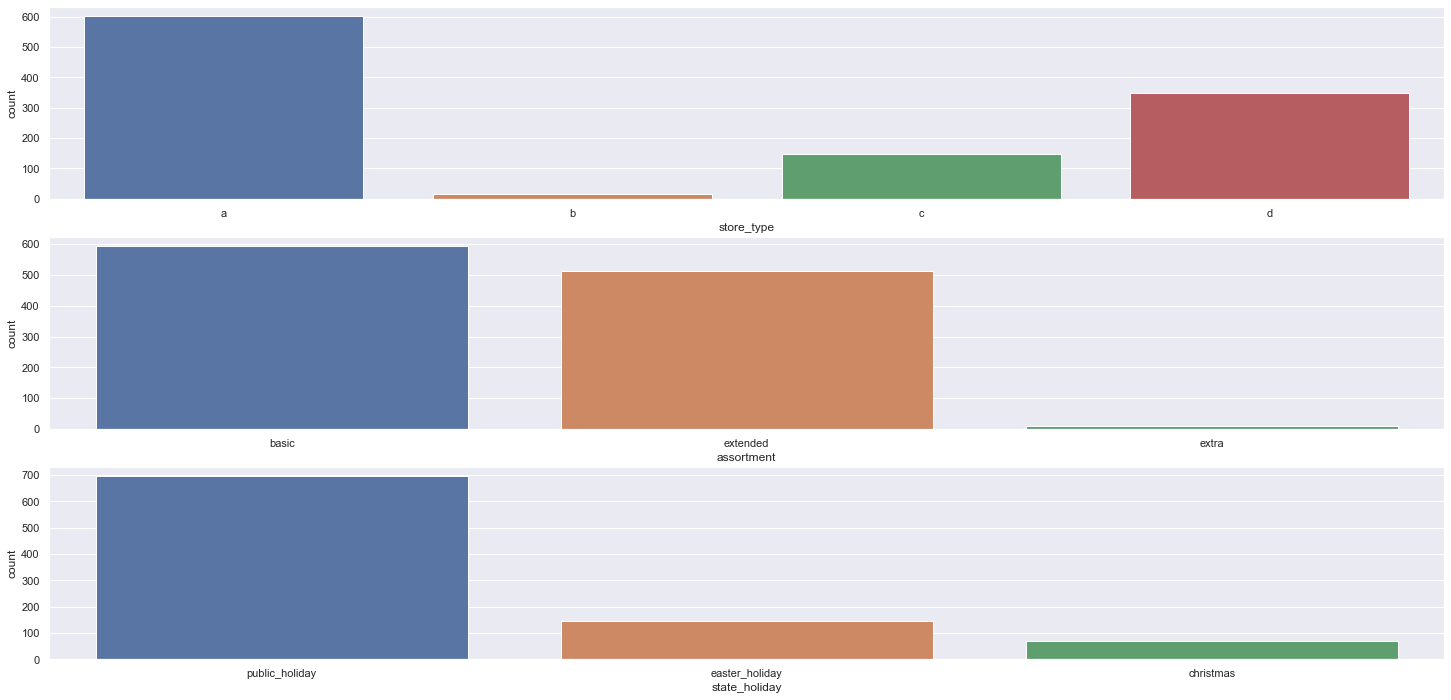

In [104]:
categorical_attributes = df5[['store','store_type','assortment','state_holiday']]
aux1 = categorical_attributes.groupby('store').agg(lambda x:x.value_counts().index[0])

plt.subplot(3, 1, 1)
sns.countplot( x='store_type', data=aux1.sort_values(by=['store_type','assortment','state_holiday']))

plt.subplot(3, 1, 2)
sns.countplot( x='assortment', data=aux1.sort_values(by=['store_type','assortment','state_holiday']))

plt.subplot(3, 1, 3)
sns.countplot( x='state_holiday', data=categorical_attributes[categorical_attributes['state_holiday'] != 'regular_day'])

## 5.2 Bivariate Analysis

The amount of information that could be drawn from this section is enormous thus I will choose to analyze only the hypothesis I stated in section 3.2

### H1 Sales should be uniform along the month (since Rosmmann is a drug store)
**FALSE** Sales can vary up to \$2000 per day due to the day of the month

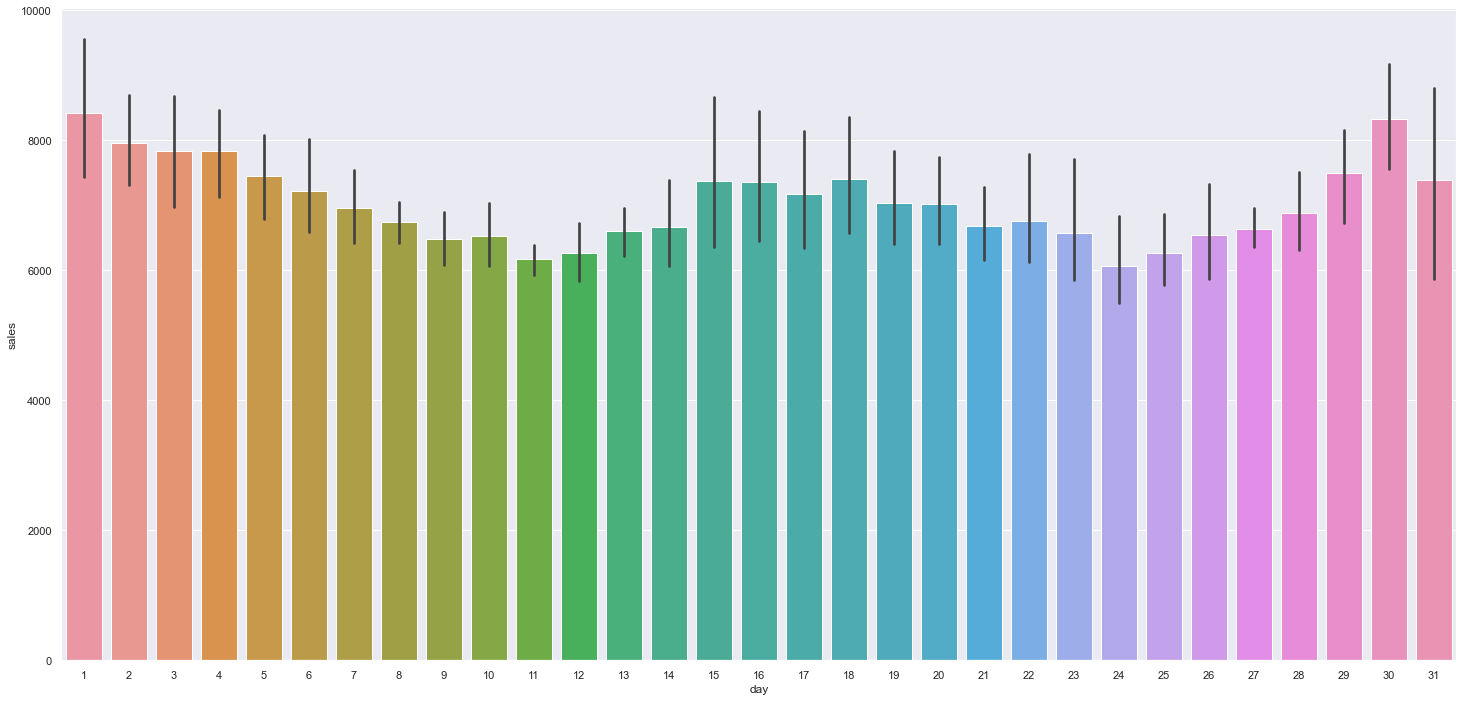

In [105]:
#sales are actually bigger close to day 1 and day 15, maybe because of payment?

aux1 = df5[['sales','month','day']].groupby(['day', 'month']).mean().reset_index()

sns.barplot(x='day',y='sales', data=aux1);

### H2 Sales should inccrease in the european winter
**FALSE** the sales during winter represent about the same percentage than other seasons

In [106]:
winter_sales = df5[((df5['day'] >= 21) & (df5['month'] == 12)) | (df5['month'] < 3) | ((df5['month'] == 3) & (df5['day'] < 20))]['sales'].sum()
pct_winter_sales=(winter_sales/df5['sales'].sum()) * 100

print(f'The sales on winter represent {pct_winter_sales:.2f}% of the total sales' )

The sales on winter represent 26.85% of the total sales


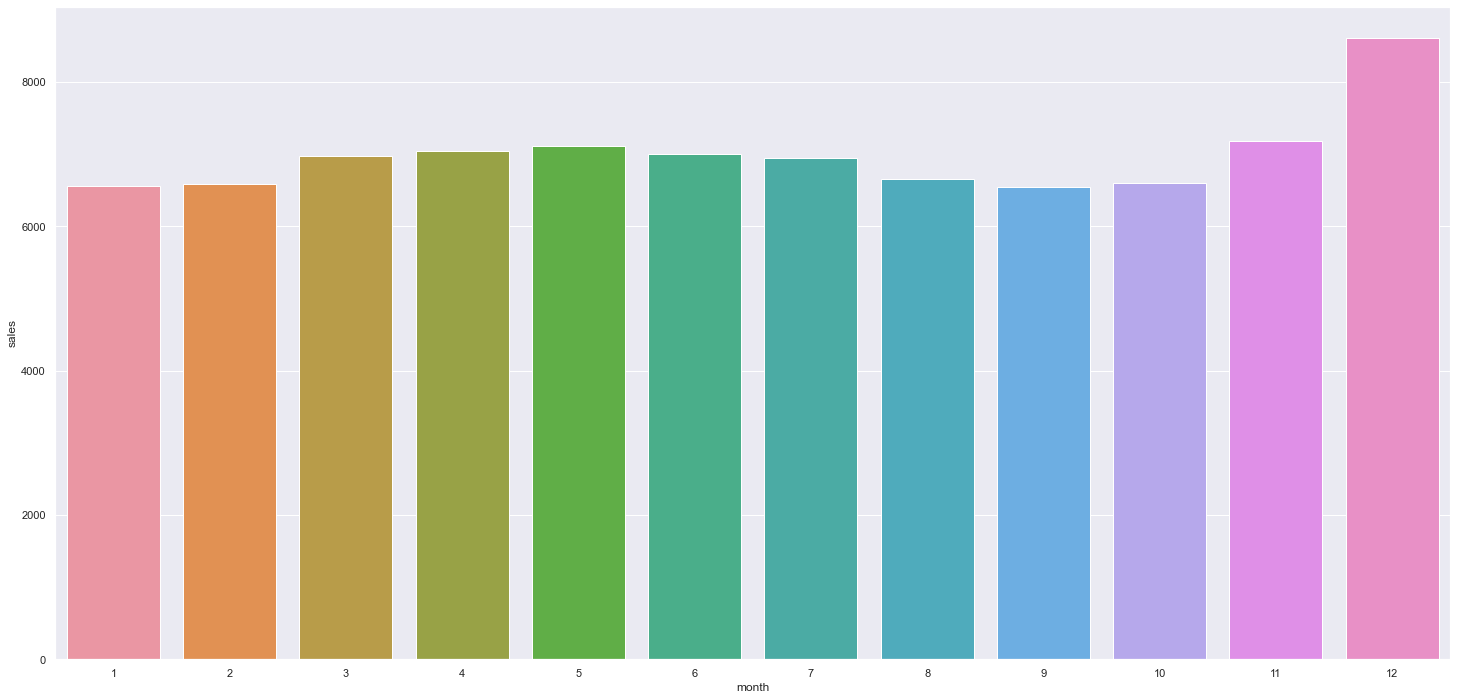

In [107]:
aux1 = df5[['month','sales']].groupby('month').mean().reset_index()

sns.barplot(x='month',y='sales',data= aux1 );

### H3 Sales should increase in promo days;
**True** for promo1 and **False** for Promo2

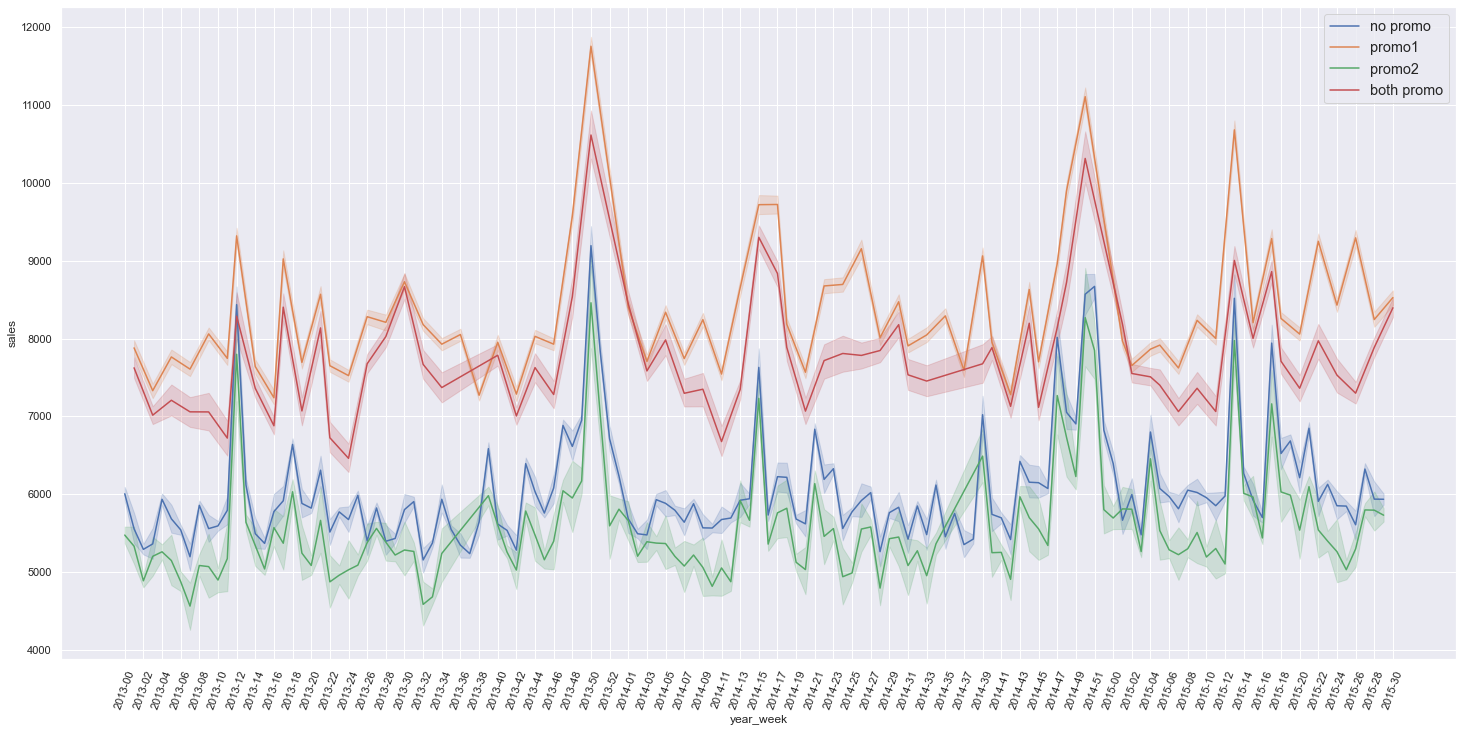

In [108]:
aux1 = df5[['sales','year_week','promo','is_promo2']].sort_values(by='year_week')

sns.lineplot(data=aux1[(aux1['promo'] == 0) & (aux1['is_promo2']==0)],x='year_week', y='sales', label='no promo');
sns.lineplot(data=aux1[(aux1['promo'] == 1) & (aux1['is_promo2']==0)],x='year_week', y='sales', label='promo1' );
sns.lineplot(data=aux1[(aux1['promo'] == 0) & (aux1['is_promo2']==1)],x='year_week', y='sales', label='promo2' );
sns.lineplot(data=aux1[(aux1['promo'] == 1) & (aux1['is_promo2']==1)],x='year_week', y='sales', label='both promo' );

plt.legend(fontsize='large');
plt.xticks(np.arange(0, len(aux1['year_week'].unique()), 2), rotation=70);

### H4 Extended assortment stores should sell more;
**True**: The more extended the assortments, greater are the sales

<AxesSubplot:xlabel='year_week'>

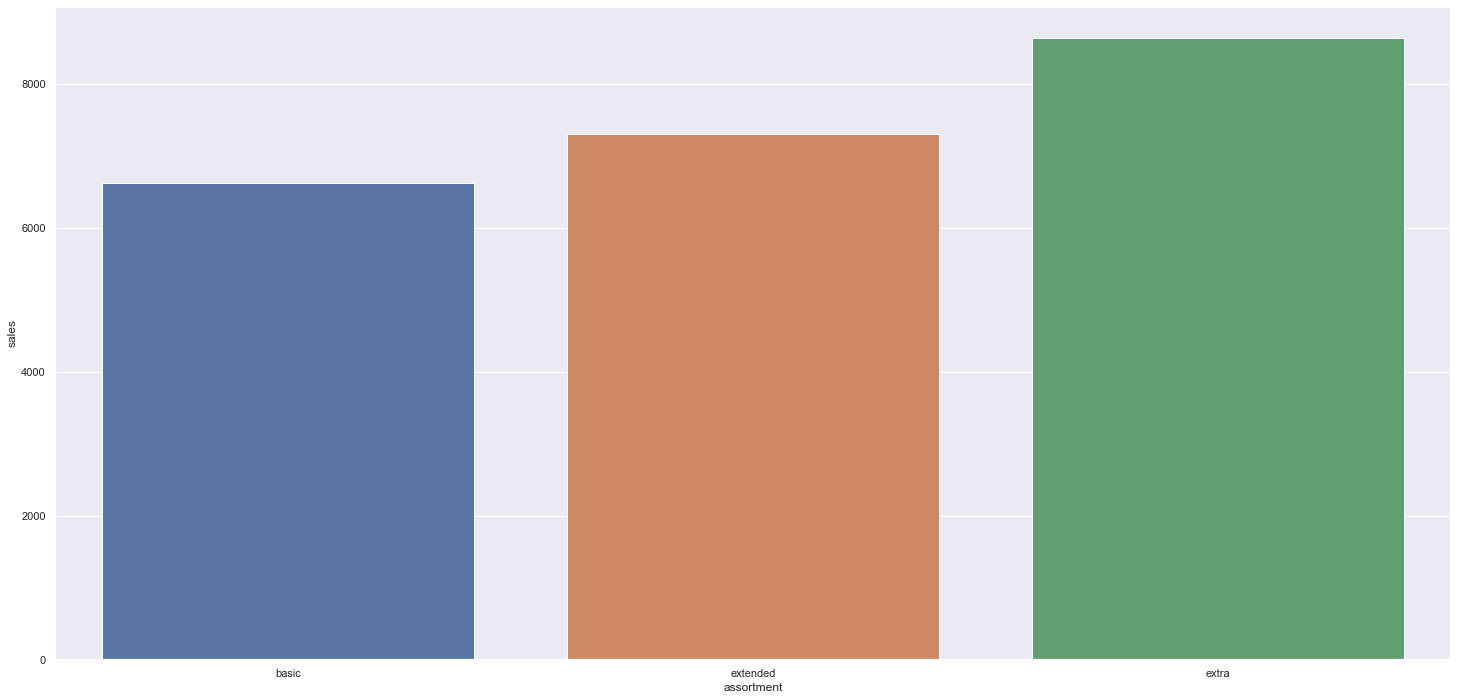

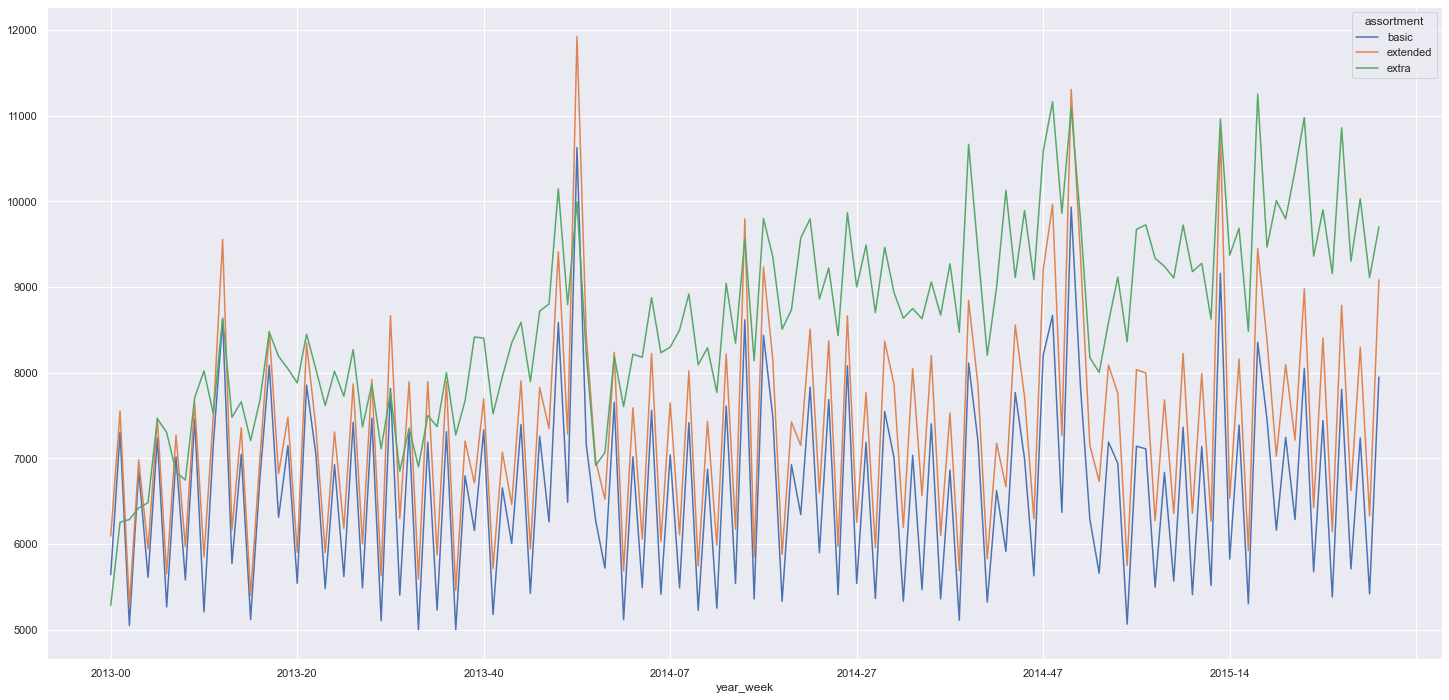

In [109]:
aux1 = df5[['sales', 'year_week','assortment']].groupby(['year_week', 'assortment']).mean().reset_index()
aux2 = df5[['sales', 'year_week','assortment']].groupby('assortment').mean().reset_index()

sns.barplot(x='assortment',y='sales',data=aux2)
aux1.pivot(index='year_week', columns='assortment', values='sales').plot()

### H5 Multiple promotions should be better than just one;
**False** Promo1 is better alone than along with promo2 (check hypothesis 3)

### H6 Sales should decrease with new competition opening;
**True** Sales decrease with competition opening

<AxesSubplot:xlabel='competition_open_since', ylabel='sales'>

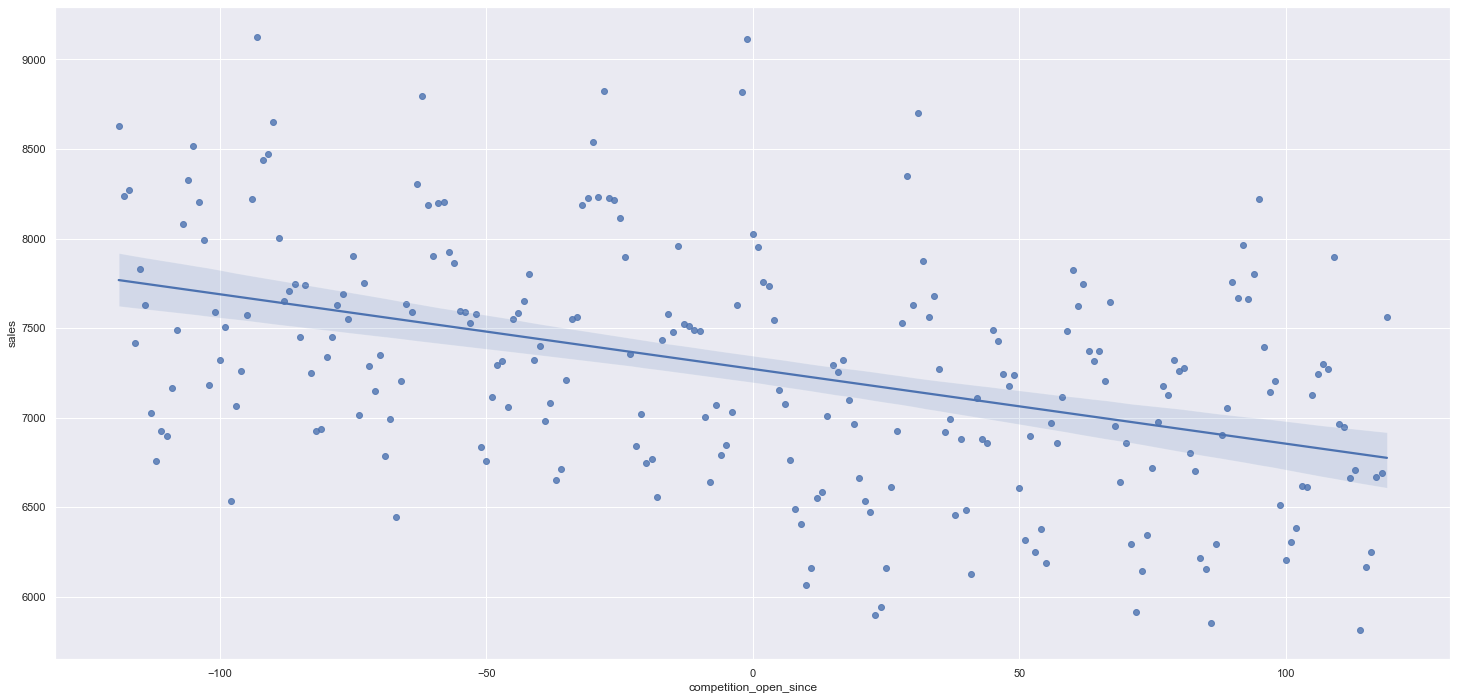

In [110]:
aux1 = df5[['sales', 'competition_open_since']]
aux1 = aux1[(aux1['competition_open_since'] < 120) & ((aux1['competition_open_since'] > -120))].groupby('competition_open_since').mean().reset_index()

sns.regplot(x='competition_open_since',y='sales',data=aux1)

### H7 Closer competitors should decrease sales;
**False** The average impact is not affected by the distance of competitors

<AxesSubplot:xlabel='competition_distance', ylabel='sales'>

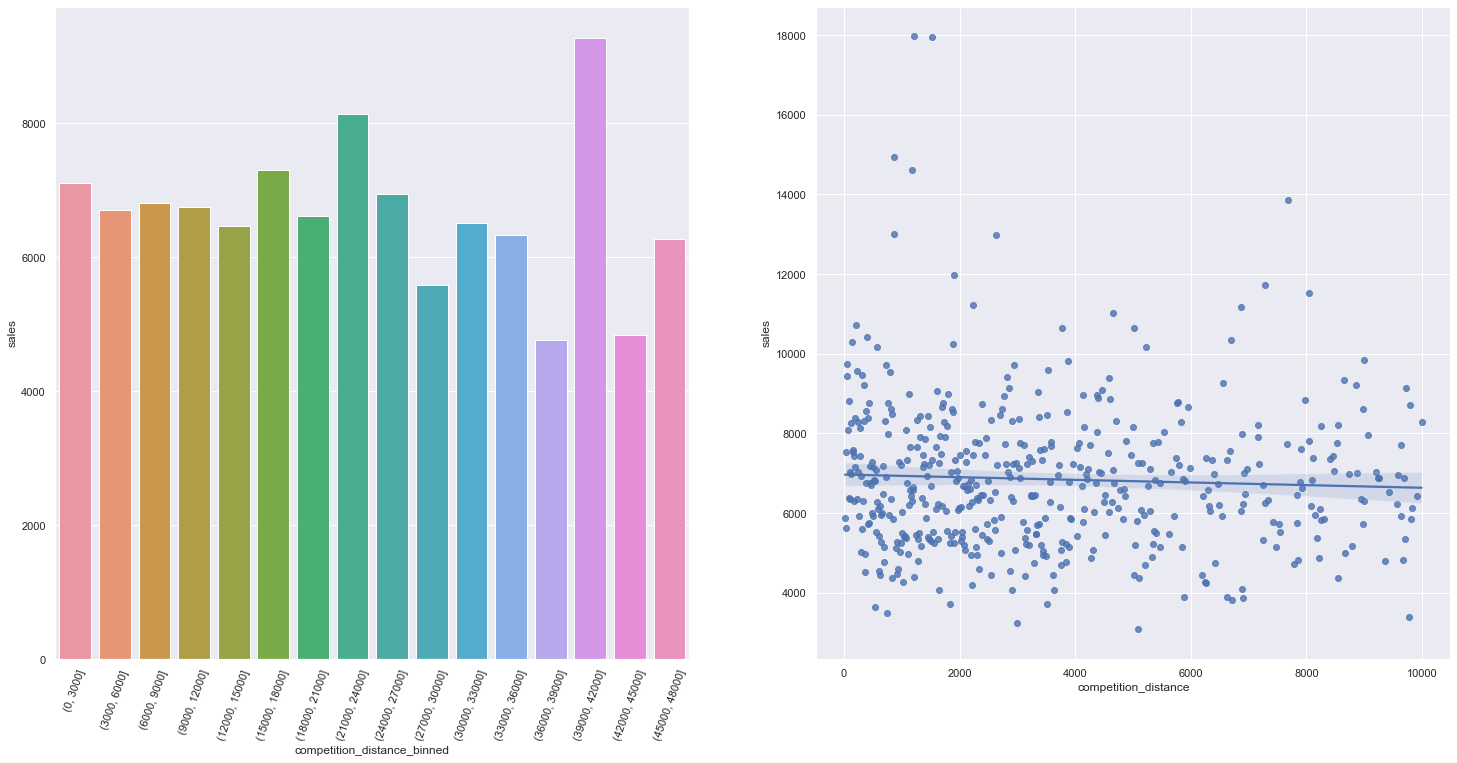

In [111]:
bins = list( np.arange( 0, 50000, 3000) )
aux1 = df5[['sales', 'competition_distance']].copy()
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux1 = aux1.groupby('competition_distance_binned').mean().reset_index()

plt.subplot(1,2,1)
plt.xticks(rotation=70)
sns.barplot(x='competition_distance_binned',y='sales',data=aux1)

aux2 = df5[['sales', 'competition_distance']].groupby('competition_distance').mean().reset_index()
aux2 = aux2[aux2['competition_distance'] < 10000]

plt.subplot(1,2,2)
sns.regplot(x='competition_distance',y='sales',data=aux2)

### H8 There should be no difference between sales in holidays or regular days.
**False** Stores sell more in holidays than on normal days

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

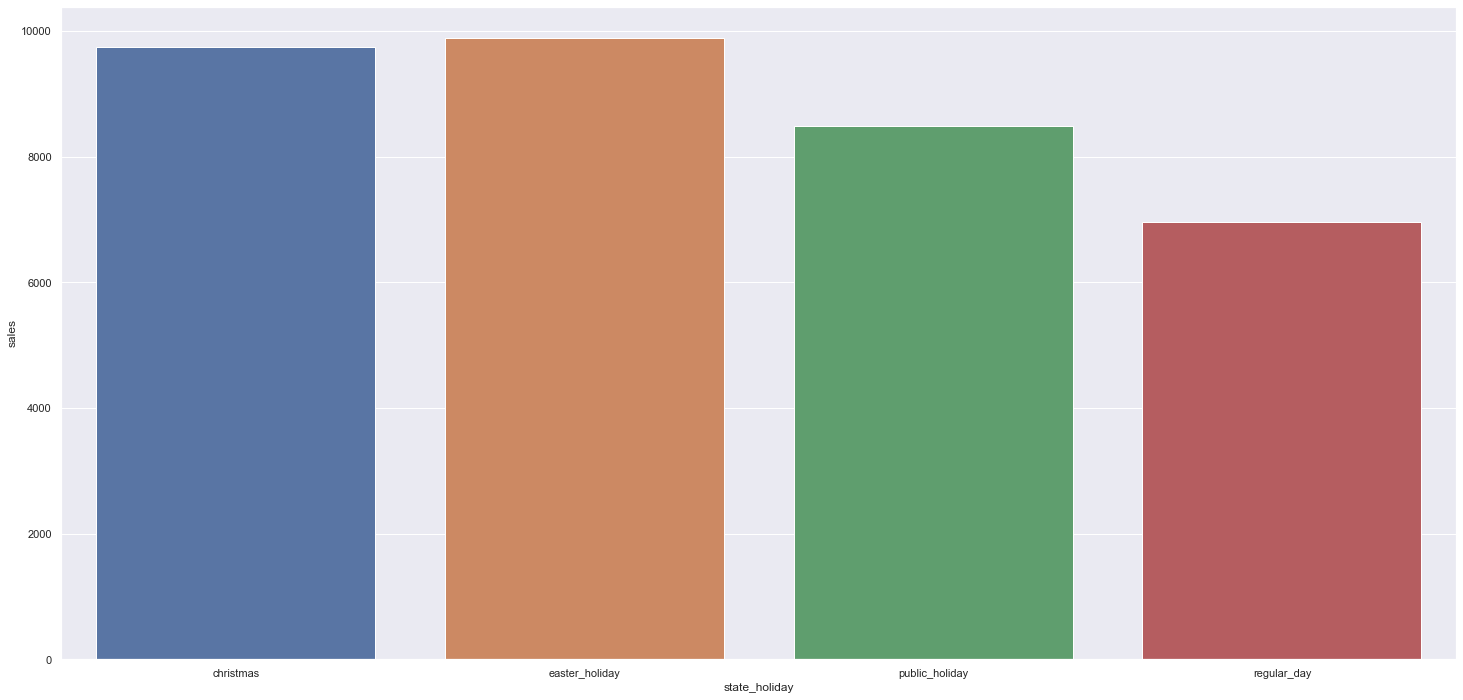

In [112]:
aux1 = df5[['sales', 'state_holiday']].groupby('state_holiday').mean().reset_index()
sns.barplot( x='state_holiday',y='sales',data=aux1)

## 5.3 Multivariate Analysis

### 5.3.1 Numerical Attributes

<AxesSubplot:>

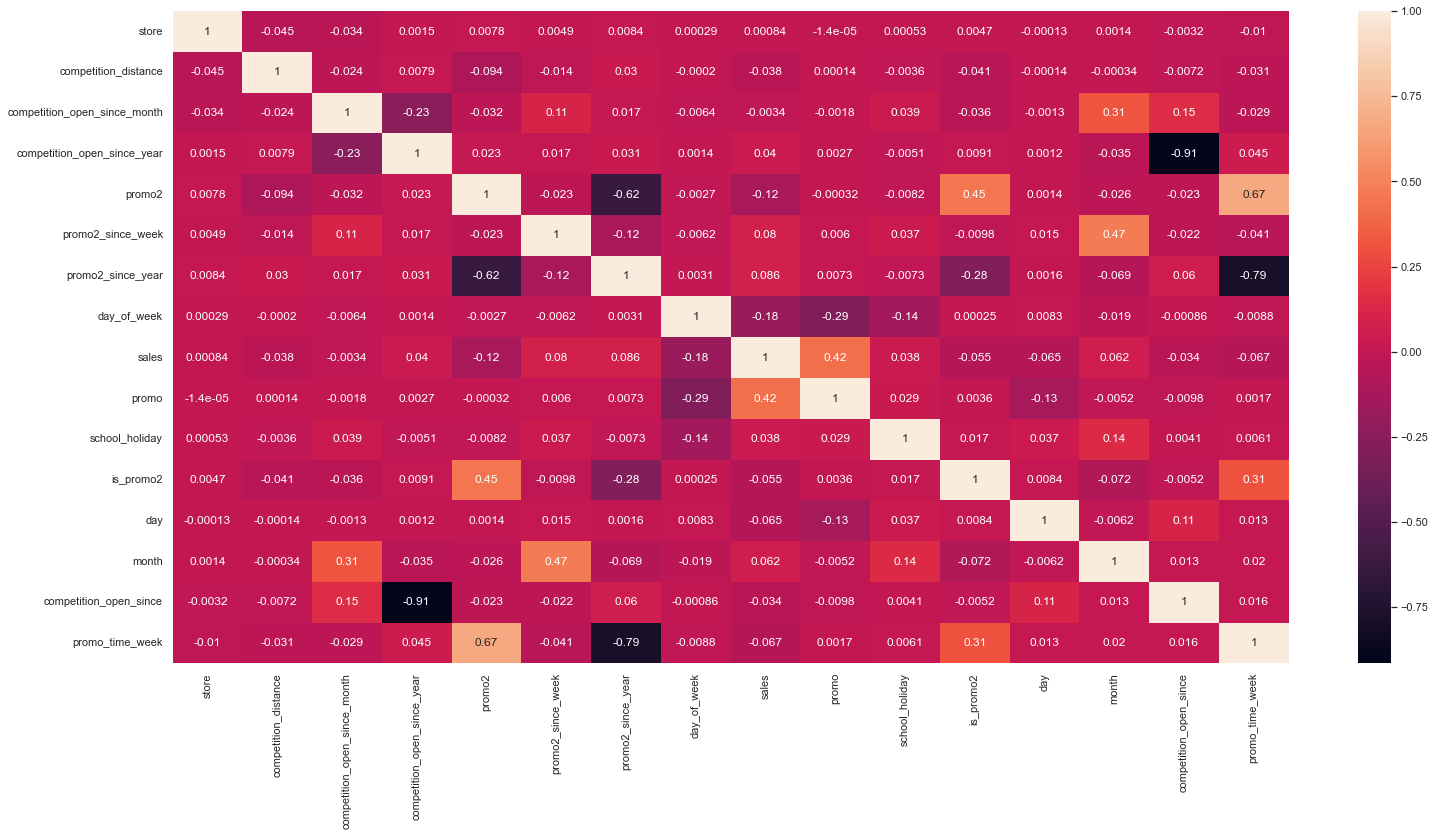

In [118]:
num_attributes = df5.select_dtypes(include=['float64', 'int64'])
num_correlations = num_attributes.corr(method='spearman')
sns.heatmap(num_correlations, annot=True)

### 5.3.2 Categorical Attributes

<AxesSubplot:>

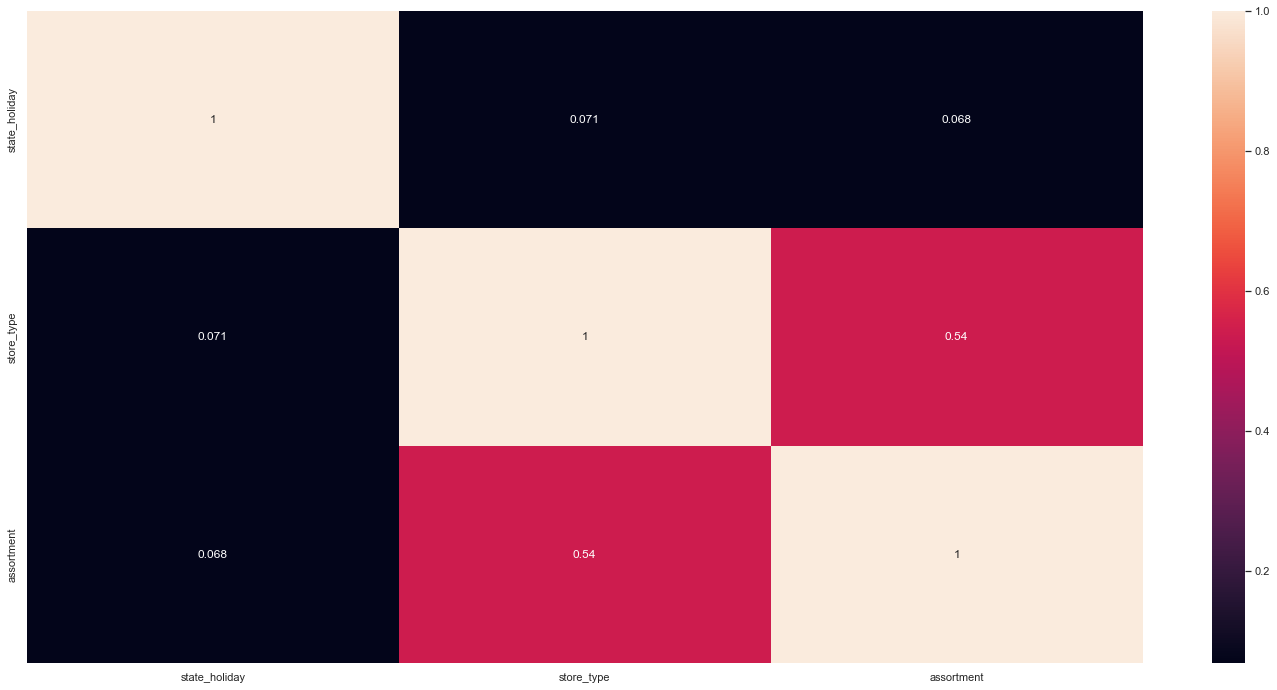

In [132]:
# cramer V is the main metric for correlation of categorical attributes
categorical_attributes = df5.select_dtypes(include='object')
categorical_attributes = categorical_attributes.drop(columns=['year_week'])

a1 = cramer_v( categorical_attributes['state_holiday'], categorical_attributes['state_holiday'] )
a2 = cramer_v( categorical_attributes['state_holiday'], categorical_attributes['store_type'] )
a3 = cramer_v( categorical_attributes['state_holiday'], categorical_attributes['assortment'] )

a4 = cramer_v( categorical_attributes['store_type'], categorical_attributes['state_holiday'] )
a5 = cramer_v( categorical_attributes['store_type'], categorical_attributes['store_type'] )
a6 = cramer_v( categorical_attributes['store_type'], categorical_attributes['assortment'] )

a7 = cramer_v( categorical_attributes['assortment'], categorical_attributes['state_holiday'] )
a8 = cramer_v( categorical_attributes['assortment'], categorical_attributes['store_type'] )
a9 = cramer_v( categorical_attributes['assortment'], categorical_attributes['assortment'] )

d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

# 6 DATA PREPARATION

In [133]:
df6 = df5.copy()

## 6.1 Normalization

## 6.2 Rescaling

## 6.3 Transformation

### 6.3.1 Encoding

### 6.3.2 Response Variable Transformation

### 6.3.3 Nature Transformation

# 7 FEATURE SELECTION

## 7.1 Split dataframe into training and test dataset

## 7.2 Boruta as Feature Selector

### 7.2.1 Best Features from Boruta

## 7.3 Manual Feature Selection

# 8 MACHINE LEARNING MODELLING

## 8.1 Average Model

## 8.2 Linear Regression Model

### 8.2.1 Linear Regression Model - Cross Validation

## 8.3 Linear Regression Regularized Model - Lasso

###  8.3.1 Lasso - Cross Validation

## 8.4 Random Forest Regressor

### 8.4.1 Random Forest Regressor - Cross Validation

## 8.5 XGBoost Regressor

### 8.5.1 XGBoost Regressor - Cross Validation

## 8.6 Compare Model's Performance

### 8.6.1 Single Performance

### 8.6.2 Real Performance - Cross Validation

# 9 HYPERPARAMETER FINE TUNING

## 9.1 Random Search

## 9.2 Final Model

# 10 TRADUCAO E INTERPRETACAO DO ERRO

## 10.1 Business Performance

## 10.2 Total Performance

## 10.3 Machine Learning Performance

# 11 DEPLOY MODEL TO PRODUCTION

## 11.1 Rossmann Class

## 11.2 API Handler

## 11.3 API Tester